Test on sample created with sample of neighbouring galaxies in uniform ditribution betwween -1 and 1 arcsecond around centered galaxy

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import sys
import os
import logging
import galsim
import random
import cmath as cm
import math
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.layers import Conv2D, Input, Dense, Dropout, MaxPool2D, Flatten,  Reshape, UpSampling2D, Cropping2D, Conv2DTranspose, PReLU, Concatenate, Lambda, BatchNormalization, concatenate
from tensorflow.keras.models import Model, Sequential
import scipy.stats as stats
from astropy.io import fits
from astropy.cosmology import WMAP9 as cosmo
%matplotlib inline

import tensorflow as tf

Using TensorFlow backend.


In [22]:
sys.path.insert(0,'../../scripts/tools_for_VAE/')
from tools_for_VAE import vae_functions, model, utils, plot

from tools_for_VAE.model import build_encoder, build_decoder
from tools_for_VAE.utils import load_deblender, load_alpha, denorm, delta_min, norm
from tools_for_VAE.plot import plot_rgb_lsst, plot_rgb_lsst_euclid, createCircularMask, mean_var, plot_corner_latent

In [417]:
import generator_deblender

In [418]:
from generator_deblender import BatchGenerator_test, BatchGenerator

In [419]:
from importlib import reload

In [420]:
reload(generator_deblender)

<module 'generator_deblender' from '/pbs/throng/lsst/users/barcelin/Deblender_VAE/notebooks/Deblender/generator_deblender.py'>

In [421]:
reload(utils)

<module 'tools_for_VAE.utils' from '../../scripts/tools_for_VAE/tools_for_VAE/utils.py'>

In [422]:
from tools_for_VAE.utils import compute_deltas_for_most_blended

In [423]:
reload(plot)

<module 'tools_for_VAE.plot' from '../../scripts/tools_for_VAE/tools_for_VAE/plot.py'>

In [424]:
from tools_for_VAE.plot import scatter_galaxies

In [425]:
from generator_deblender import BatchGenerator_test, BatchGenerator

# Function to import dense VAE

In [223]:
# Parameters
batch_size = 100
original_dim = 64*64*6

In [224]:
alpha = K.variable(1e-4)
deblender, encoder, Dkl = load_deblender('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4+uni11/', '/sps/lsst/users/barcelin/weights/LSST/VAE/noisy/v8/mse/', 6, folder = True)
# '/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'
K.set_value(alpha, load_alpha('/sps/lsst/users/barcelin/weights/LSST/deblender/noisy/v4/'))

def deblender_loss(x, x_decoded_mean):
    xent_loss = K.mean(K.sum(K.binary_crossentropy(x, x_decoded_mean), axis=[1,2,3]))#original_dim*
    kl_loss = K.get_value(alpha) * Dkl
    return xent_loss + K.mean(kl_loss)

deblender.compile('adam', loss=deblender_loss, metrics=['mse'])

## Stamp size for plots

In [225]:
phys_stamp_size = 6.4 # arcsec
pixel_scale_euclid_vis = 0.1 # arcsec/pixel

stamp_size = int(phys_stamp_size/pixel_scale_euclid_vis)

# Load test list

In [388]:
r= np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/uni11/galaxies_COSMOS_test_redshift_v5.npy')

In [389]:
mag = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/uni11/galaxies_COSMOS_test_magnitude_v5.npy')

In [390]:
shift = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/uni11/galaxies_COSMOS_test_shift_v5.npy')

In [391]:
blendedness_lsst = np.load('/sps/lsst/users/barcelin/data/blended/COSMOS/uni11/galaxies_COSMOS_test_blendedness_lsst_v5.npy')

# Batch generation

In [392]:
list_of_samples = ['/sps/lsst/users/barcelin/data/blended/COSMOS/uni11/galaxies_COSMOS_test_v5.npy']#/sps/lsst/users/barcelin/data/blended/COSMOS/galaxies_COSMOS_test_2_v4.npy

In [393]:
list_of_shifts = ['/sps/lsst/users/barcelin/data/blended/COSMOS/uni11/galaxies_COSMOS_test_shift_v5.npy']

In [394]:
bands = [4,5,6,7,8,9]

In [395]:
batch_gen = BatchGenerator(bands, list_of_samples,total_sample_size=10000, batch_size= 100, magnitude = mag, shift = shift, blendedness = blendedness_lsst, trainval_or_test = 'test', noisy = True)#_lsst_process

## LSST only

(100,) [24.35258549518559, 28.71692531686275, 26.439395861080968, 27.649665054221213]
OK


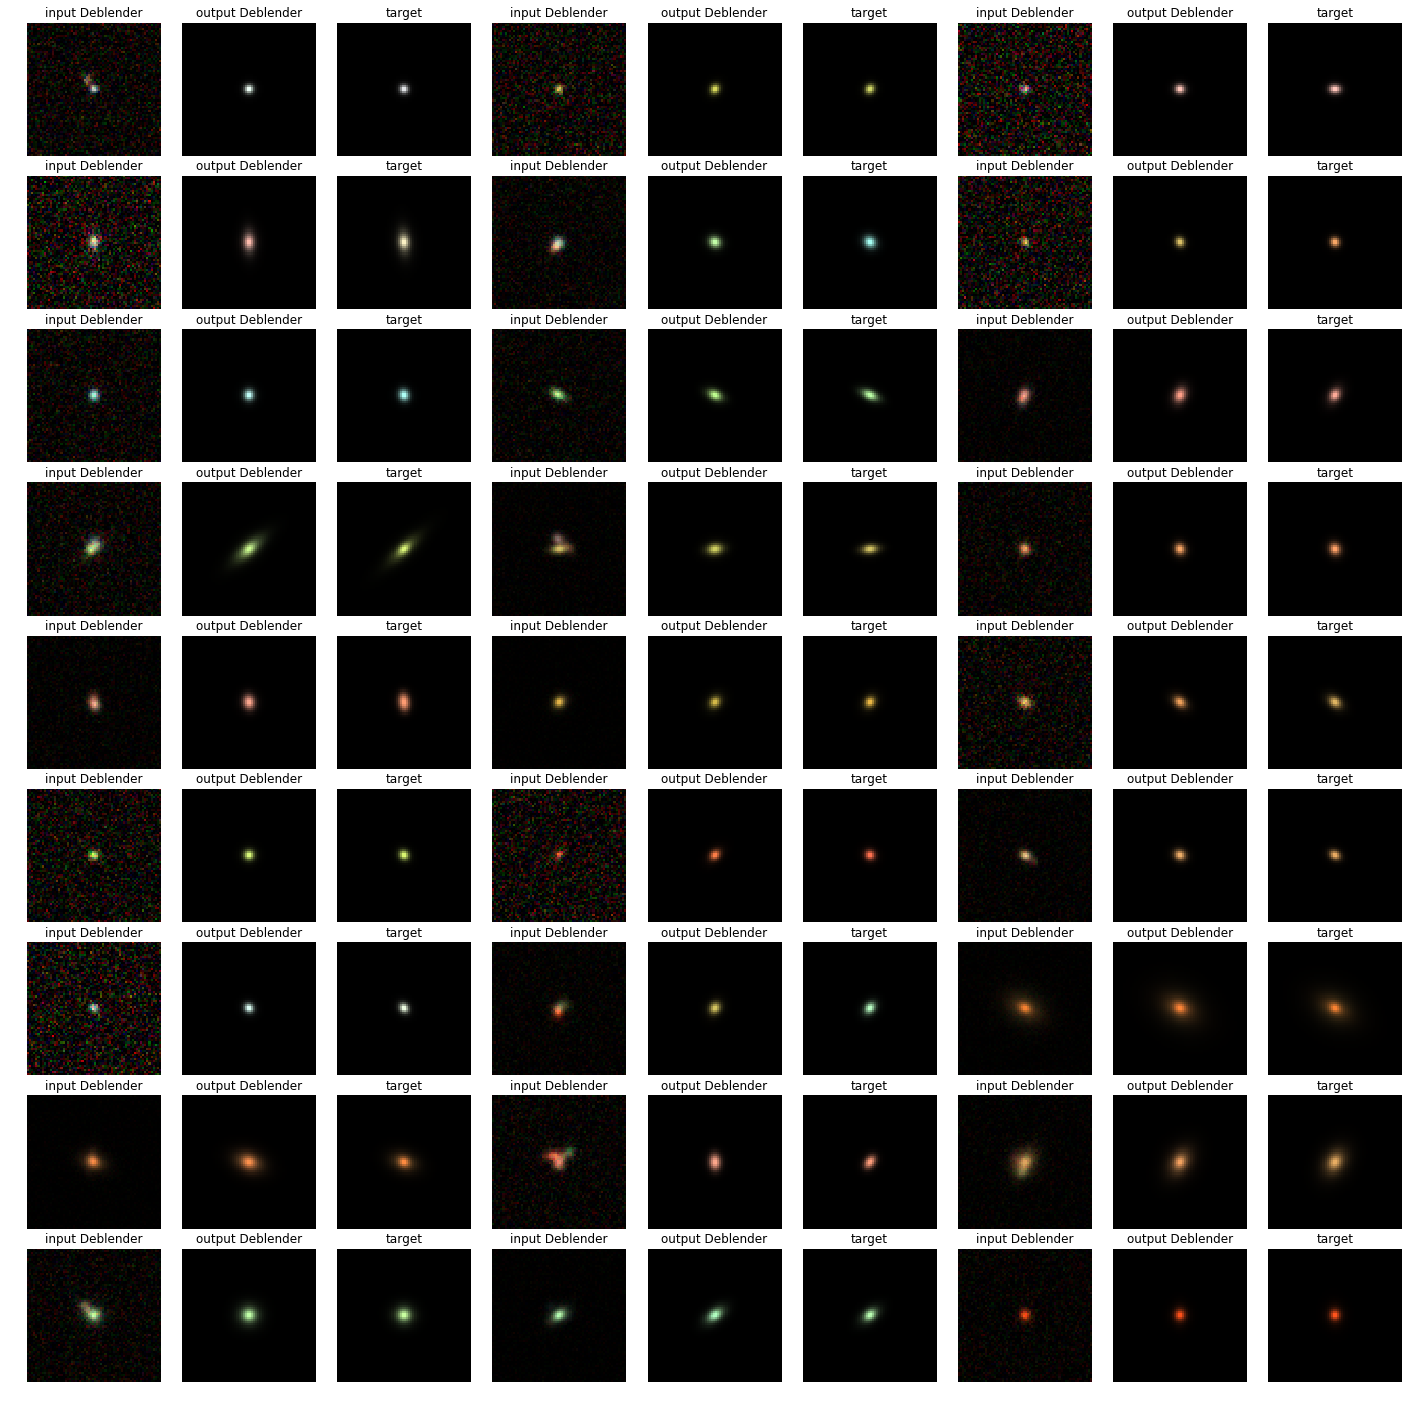

In [234]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]],stamp_size, axes[i,j])#input_vae
        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]],stamp_size, axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]],stamp_size, axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

In [402]:
N_plot = 3

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]
blendedness_lsst = input_lsst[7]

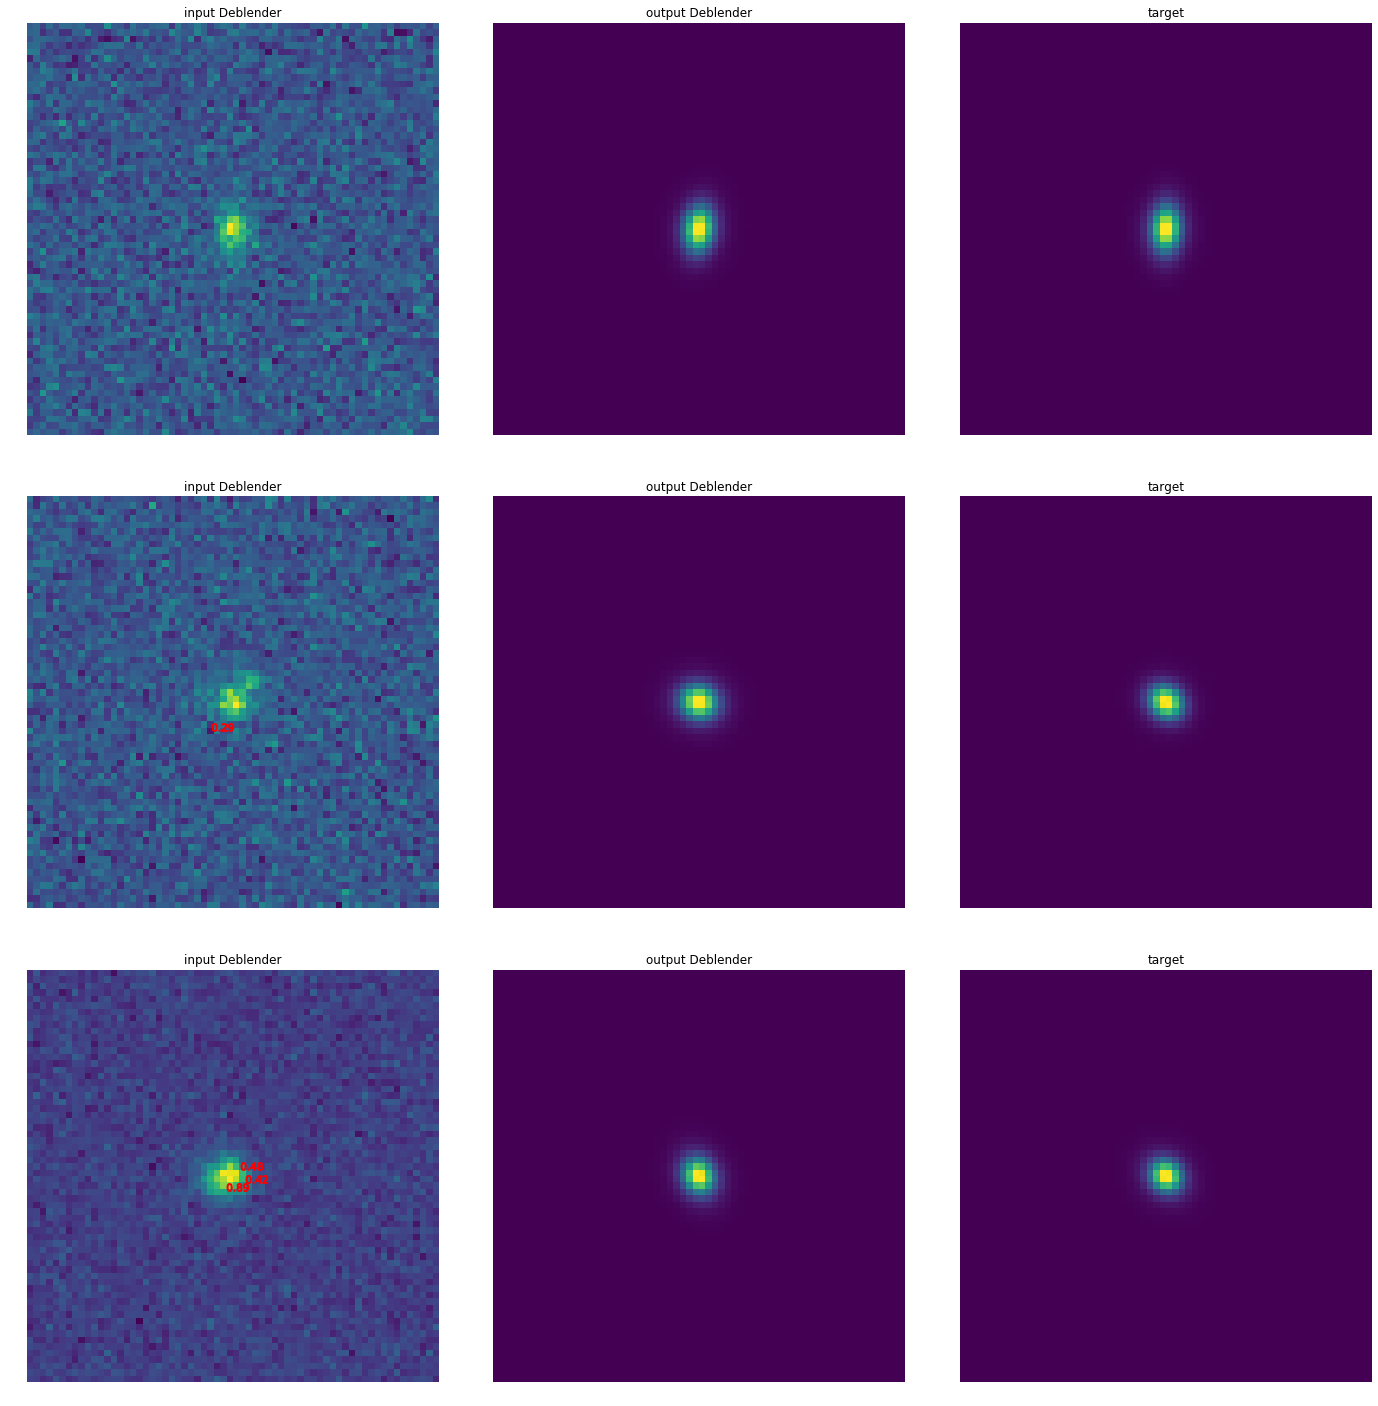

In [403]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        scatter_galaxies(input_noisy[indices[i*N_plot+j]][:,:,2], shift[indices[i*N_plot+j]],0.2,64,scatter = 'blendedness', blendedness = blendedness_lsst[indices[i*N_plot+j]], ax = axes[i,j])

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][:,:,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][:,:,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

In [404]:
N_plot = 9

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]
blendedness_lsst = input_lsst[7]

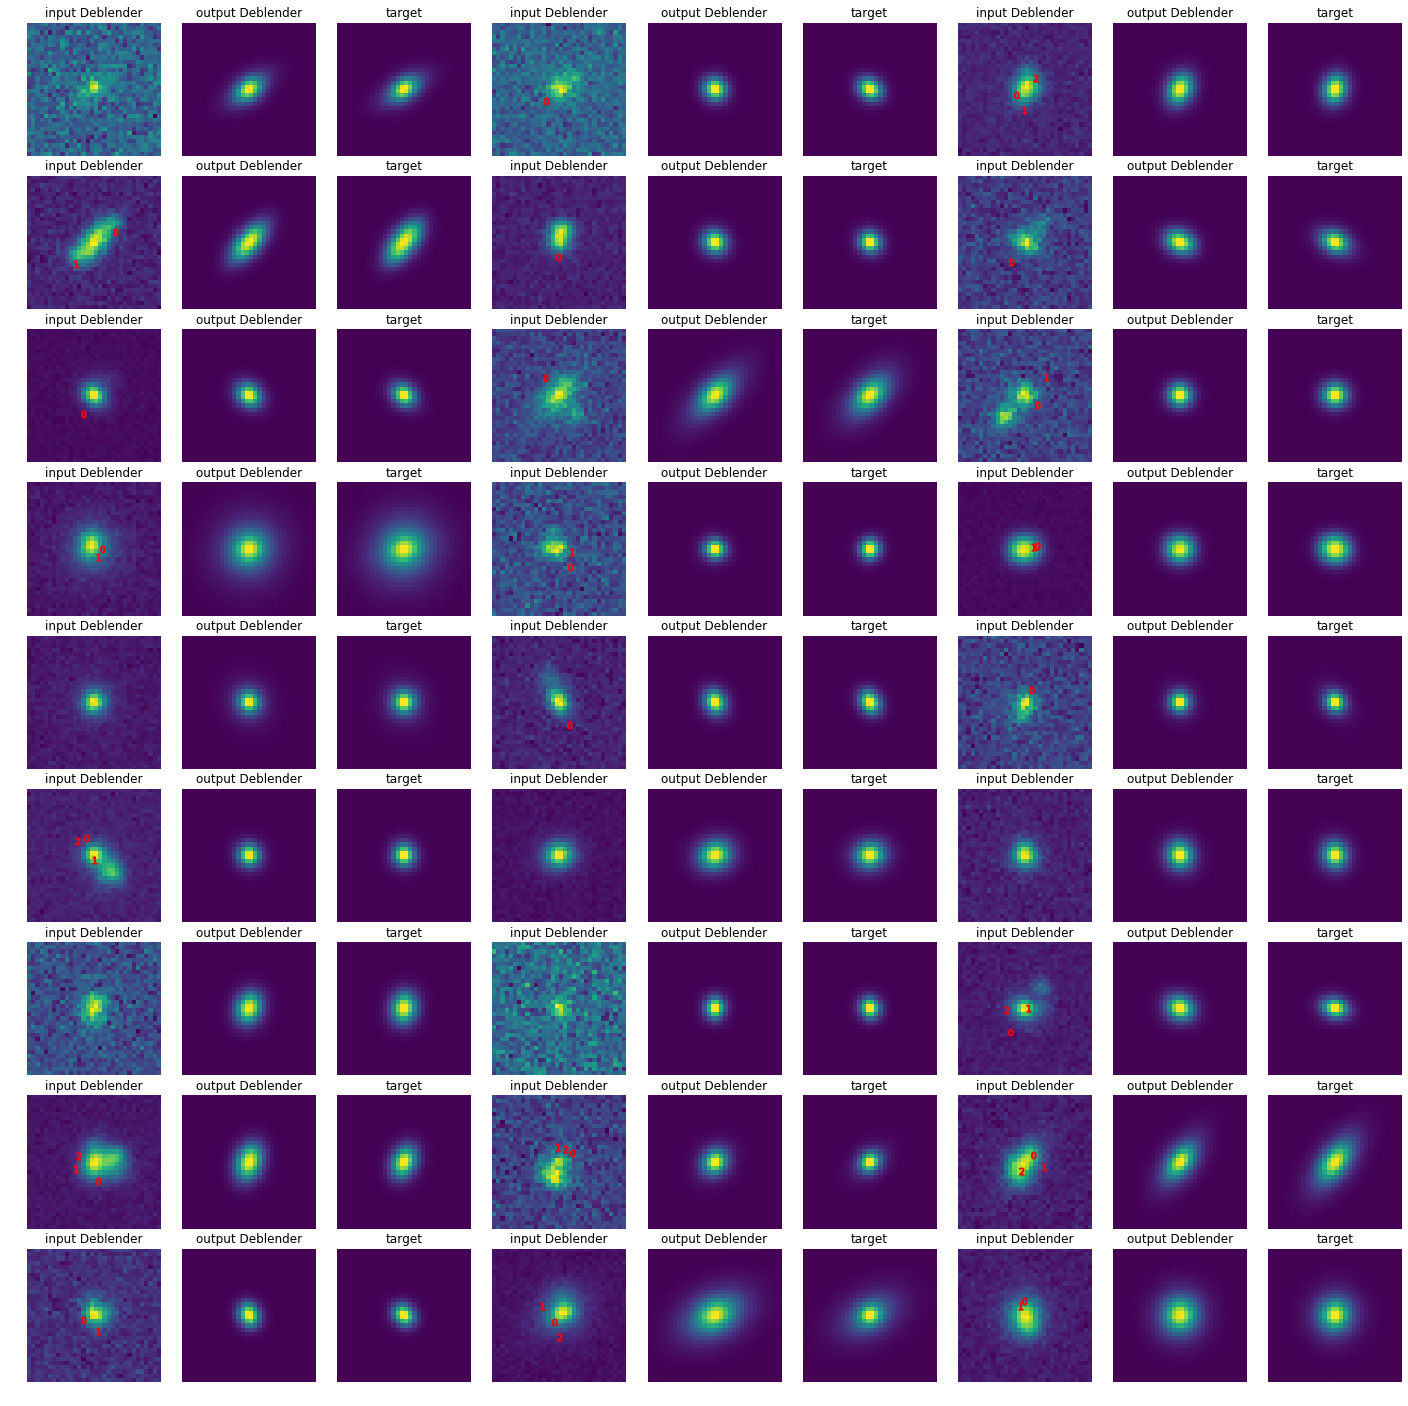

In [426]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        scatter_galaxies(input_noisy[indices[i*N_plot+j]][:,:,2], shift[indices[i*N_plot+j]],0.2,64, ax = axes[i,j])

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][:,:,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][:,:,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

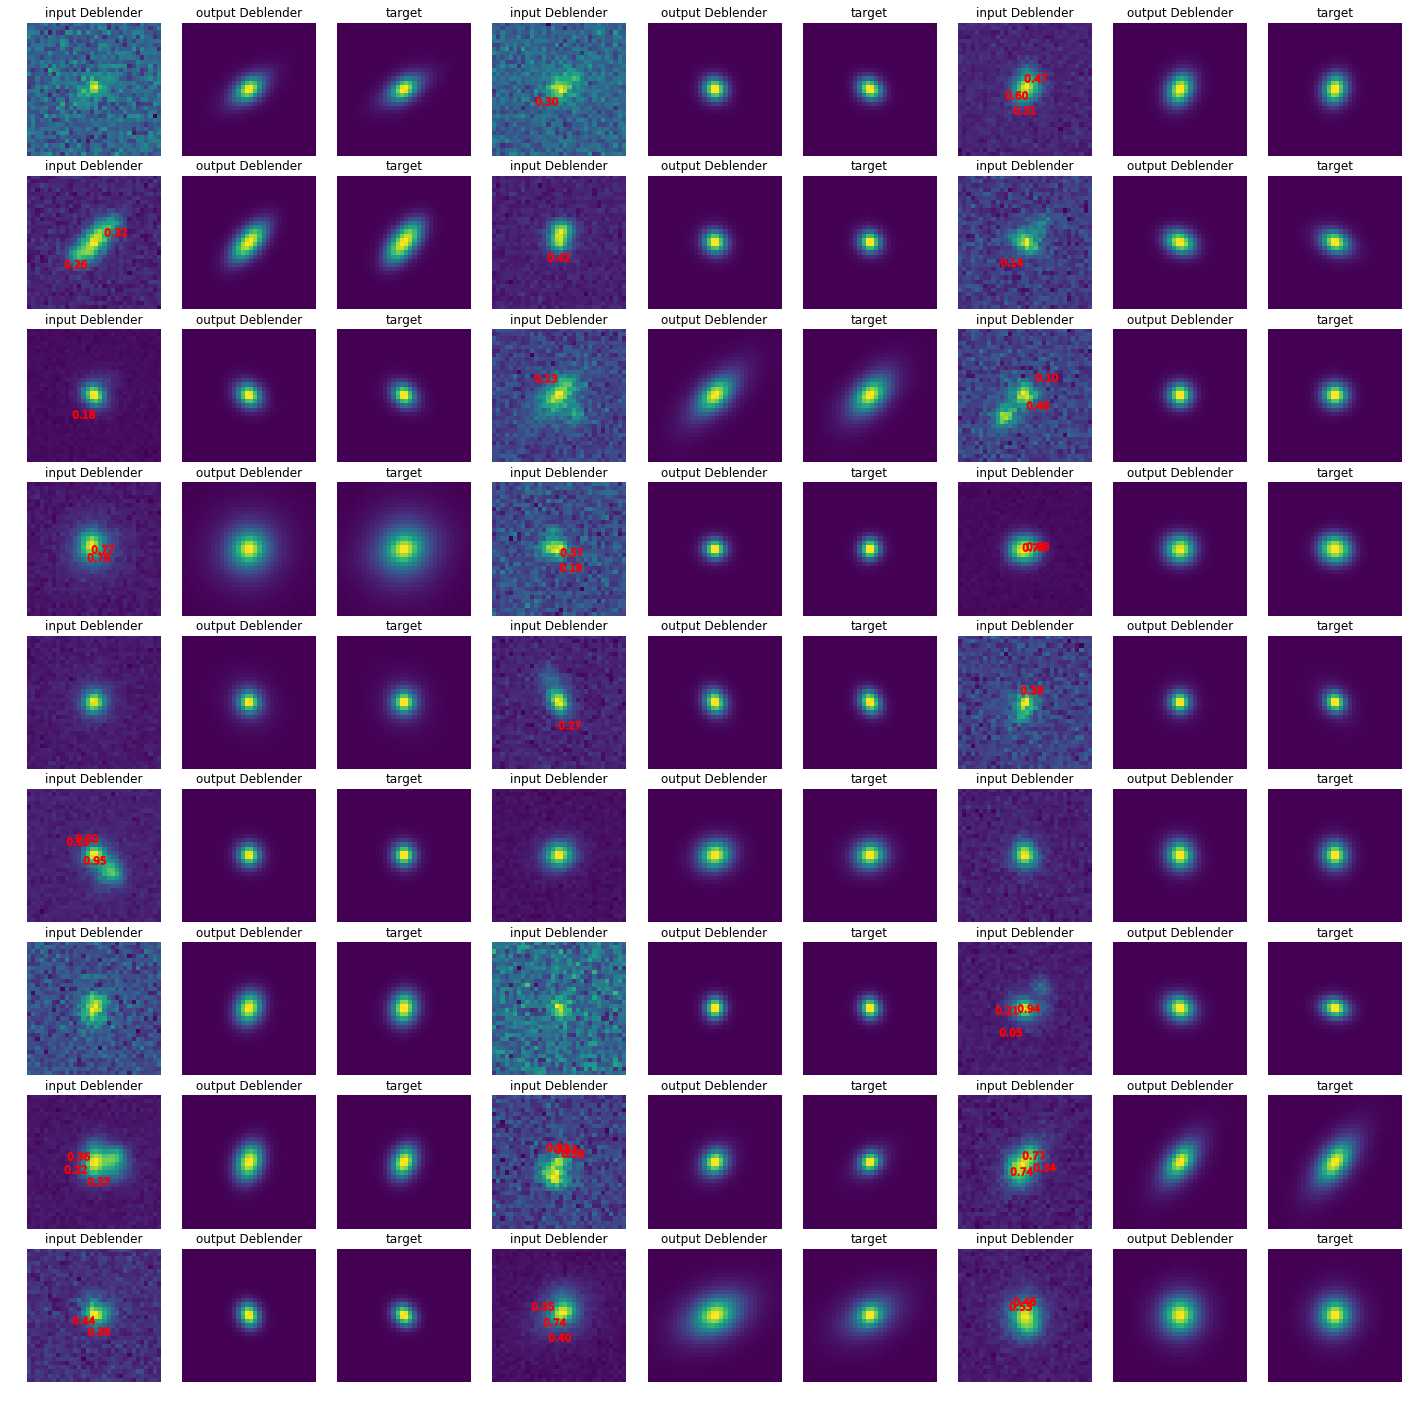

In [415]:
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

for i in range(N_plot):
    for j in range(0,N_plot,3):
        scatter_galaxies(input_noisy[indices[i*N_plot+j]][:,:,2], shift[indices[i*N_plot+j]],0.2,64,scatter = 'blendedness', blendedness = blendedness_lsst[indices[i*N_plot+j]], ax = axes[i,j])

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][:,:,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][:,:,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

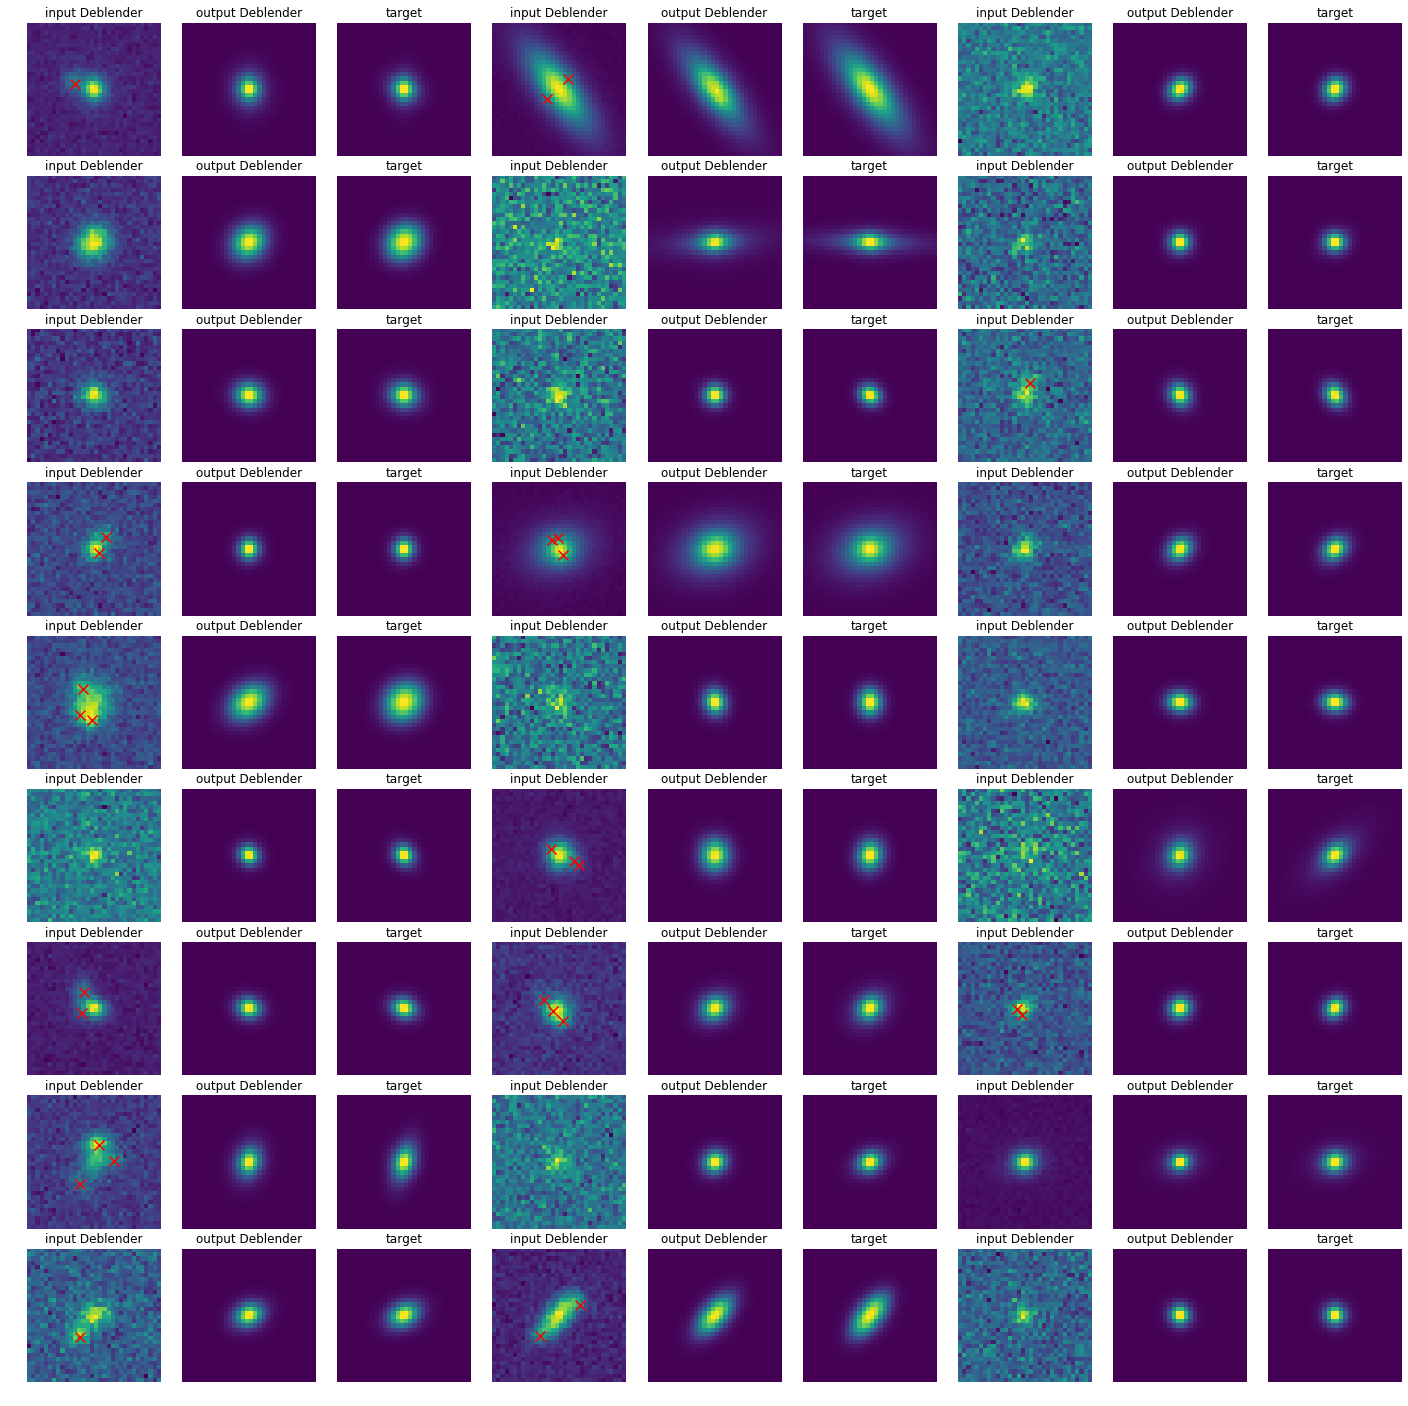

In [46]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)

mag = input_lsst[2]
shift = input_lsst[3]

for i in range(N_plot):
    for j in range(0,N_plot,3):
        axes[i,j].imshow(input_noisy[indices[i*N_plot+j]][16:48,16:48,2])
        
        for k in range (len(shift[indices[i*N_plot+j]])):
            axes[i,j].scatter(16+shift[indices[i*N_plot+j]][k][0]/0.2, 16+shift[indices[i*N_plot+j]][k][1]/0.2,s = 100,c='red', marker='x')

        axes[i,j+1].imshow(output_deblender_lsst[indices[i*N_plot+j]][16:48,16:48,2])
        axes[i,j+2].imshow(input_noiseless[indices[i*N_plot+j]][16:48,16:48,2])
        
        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')
        
        

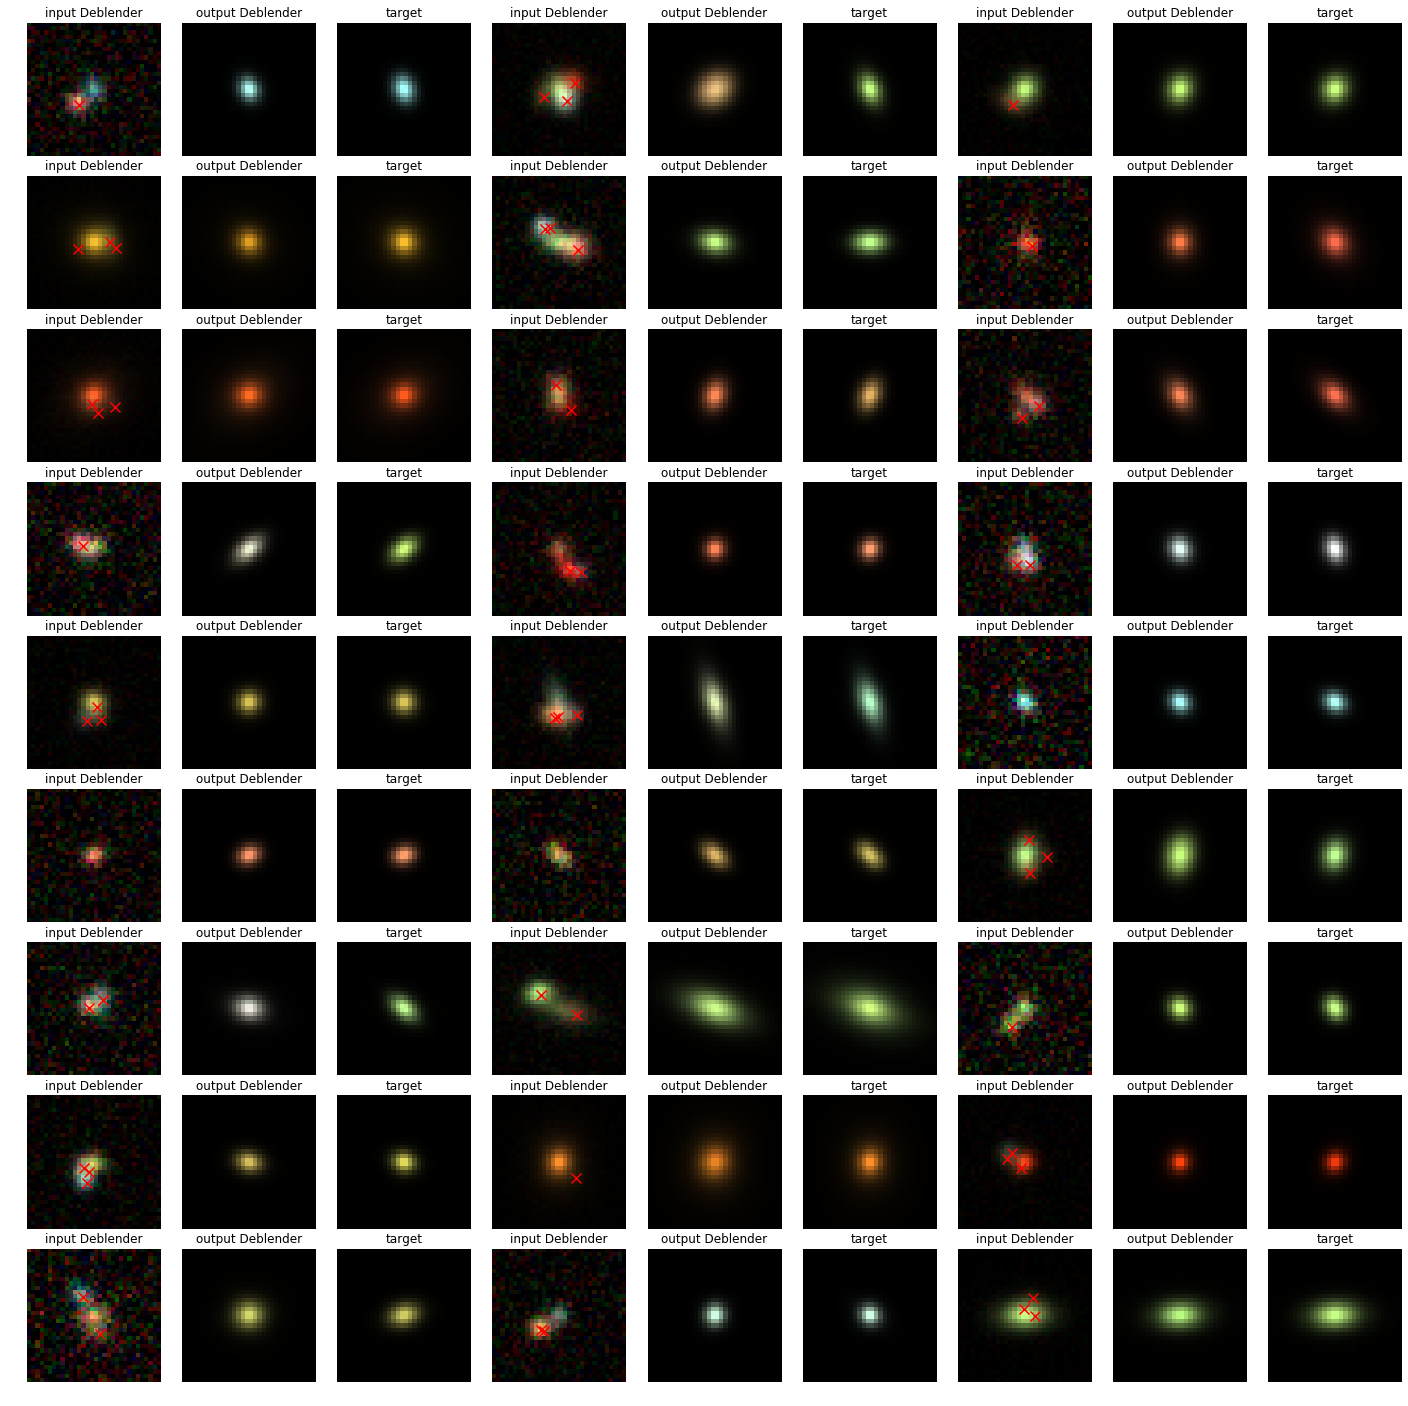

In [73]:
N_plot = 9
fig, axes = plt.subplots(N_plot, N_plot, figsize=(25, 25))
fig.subplots_adjust(wspace=.01, hspace=.15)

indices = np.random.choice(100, size=N_plot*N_plot, replace=False)

input_lsst = batch_gen.__getitem__(2)
input_noisy = input_lsst[0]
input_noiseless = input_lsst[1]
shift = input_lsst[3]

output_deblender_lsst = deblender.predict(input_lsst[0], batch_size = 100)

output_deblender_lsst = denorm(output_deblender_lsst, bands, channel_last = True)
input_noisy = denorm(input_noisy, bands, channel_last = True)
input_noiseless = denorm(input_noiseless, bands, channel_last = True)


for i in range(N_plot):
    for j in range(0,N_plot,3):
        plot_rgb_lsst(input_noisy[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j])#input_vae
        for k in range (len(shift[indices[i*N_plot+j]])):
            axes[i,j].scatter(16+shift[indices[i*N_plot+j]][k][0]/0.2, 16+shift[indices[i*N_plot+j]][k][1]/0.2,s = 100,c='red', marker='x')

        plot_rgb_lsst(output_deblender_lsst[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j+1])#output_vae
        plot_rgb_lsst(input_noiseless[indices[i*N_plot+j]][16:48,16:48],int(stamp_size/2), axes[i,j+2])#output_vae

        axes[i,j].axis('off')
        axes[i,j].set_title('input Deblender')
        axes[i,j+1].axis('off')
        axes[i,j+1].set_title('output Deblender')
        axes[i,j+2].axis('off')
        axes[i,j+2].set_title('target')

# Shape reproduction

In [241]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
magnitudes = []
deltas_r = []
deltas_m = []
max_blendedness = []

N = 100
lum_in_simple = np.empty([N,N,],dtype='float32')
lum_out_simple= np.empty([N,N,], dtype='float32')



for j in range(N):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0], batch_size = batch_size)
    output_vae = denorm(output_vae, bands, channel_last = True)
    input_noiseless = denorm(a[1], bands, channel_last = True)

    for i in range (len(a[0])):#a[0] test
        try: 
            gal_image = galsim.Image(input_noiseless[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_in = [res.corrected_e1, res.corrected_e2]

            gal_image = galsim.Image(output_vae[i][:,:,2])
            gal_image.scale = pix_scale

            res = galsim.hsm.EstimateShear(gal_image, psf_image)
            e_out = [res.corrected_e1, res.corrected_e2]

            ellipticities.append([e_in, e_out])

            magnitudes.append(a[2])
            
            
            
            # Measurement of fluxes
            mask = createCircularMask(64,64,None,5)
            masked_img_in_simple = a[1][i][:,:,2].copy()
            masked_img_in_simple[~mask] = 0  

            masked_img_out_simple = output_vae[i][:,:,2].copy()
            masked_img_out_simple[~mask] = 0

            # Calculate the luminosity by substracting the noise
            lum_in_simple[j,i] = np.sum(masked_img_in_simple)
            #print(lum_in_simple[j,i])
            lum_out_simple[j,i] = np.sum(masked_img_out_simple)

            
            
        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue
          
    delta_r = a[4] 
    delta_mag = a[5]
    max_blend = a[6]
    deltas_r.append(delta_r)
    deltas_m.append(delta_mag)
    max_blendedness.append(max_blend)

ellipticities_r_band = np.array(ellipticities)
magnitudes = np.array(magnitudes)
delta_r_arr = np.array(deltas_r)
delta_mag_arr = np.array(deltas_m)
max_blendedness_arr = np.array(max_blendedness)

(100,) [24.05365729253002]
OK
(100,) [28.14030252726638, 27.60991527678829, 28.8430711262263]
OK
(100,) [25.484540330432083]
OK
(100,) [27.538848823078883, 27.6990916670051, 27.08925698258293]
OK
(100,) [27.400695017345196, 27.880858640122323]
OK
(100,) [26.81759912498873, 23.452817851586076]
OK
(100,) [28.591320339808146, 28.89347212528132]
OK
(100,) [26.44041540322486, 28.222007031794185, 29.051712513707837]
OK
(100,) [27.525470566381347, 24.670610814942393]
OK
(100,) [27.67431978858015, 27.755779491661876, 27.444398114534817, 27.425017742515237]
OK
(100,) [26.97637383941796, 28.159252058384002]
OK
(100,) [27.33560050945282, 27.712927049301413]
OK
(100,) [27.63335332017133, 27.93398827043971, 26.99289415309472, 24.14270048046093]
OK
(100,) [27.885443632523796, 27.210539482477028, 27.013121094145248]
OK
(100,) [28.473712869568768, 27.013434120809173, 27.345046139866568, 27.52732500979109]
OK
(100,) [26.282203022546664, 27.84083039119963]
OK
(100,) [27.18208574807929, 26.35310601636495

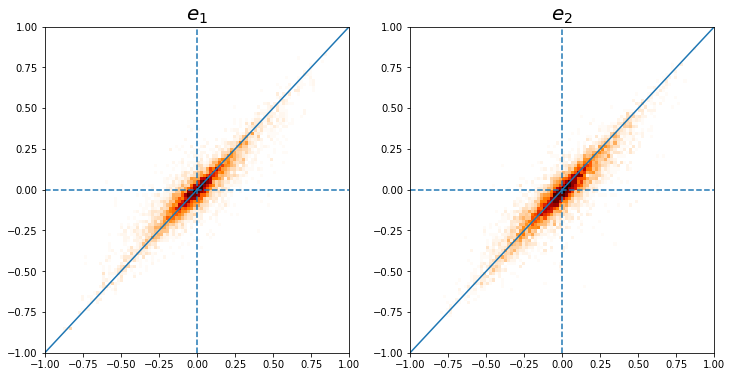

In [242]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'
    

In [243]:
import seaborn as sns

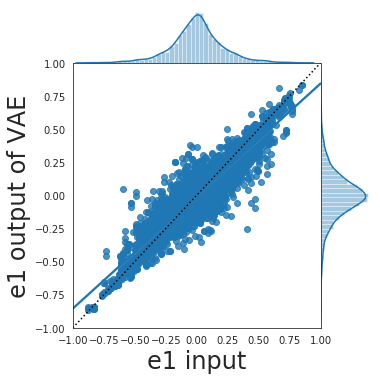

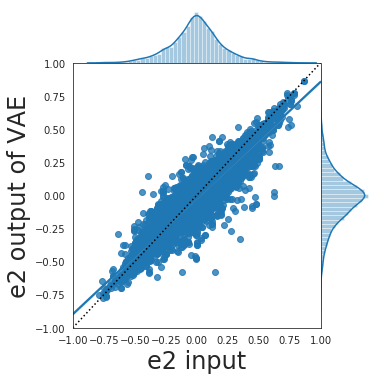

In [244]:
with sns.axes_style('white'):
            g = sns.jointplot(ellipticities_r_band[:,0,0], ellipticities_r_band[:,1,0], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e1 input', 'e1 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

            g = sns.jointplot(ellipticities_r_band[:,0,1], ellipticities_r_band[:,1,1], kind='reg',height =5,
                              xlim =[-1, 1], ylim=[-1, 1], space=0).set_axis_labels('e2 input', 'e2 output of VAE', fontsize=24)
            g.ax_joint.plot(np.linspace(-1, 1),
                            np.linspace(-1, 1), ':k')

In [256]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

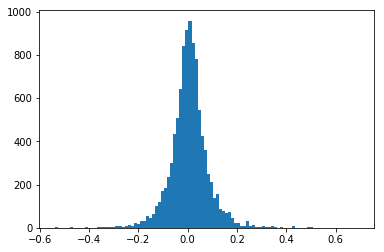

In [80]:
_ = plt.hist(delta_e1, bins = 100)

###### Luminosity

In [255]:
lum_in_simple = np.concatenate(lum_in_simple)
lum_out_simple = np.concatenate(lum_out_simple)

ValueError: zero-dimensional arrays cannot be concatenated

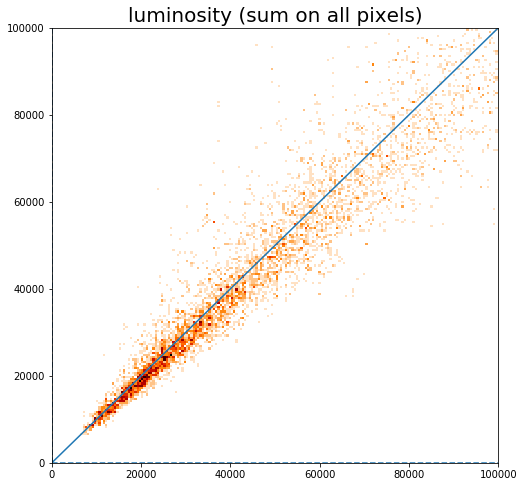

In [246]:
import matplotlib as mpl

max_lum = np.max(lum_in_simple)

fig, axes = plt.subplots(1,1, figsize=(8,8))
emax = 100000
_ = axes.hist2d(lum_in_simple, lum_out_simple, bins=np.linspace(0,+emax,200), cmap=mpl.cm.gist_heat_r)
axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')

(0, 100000)

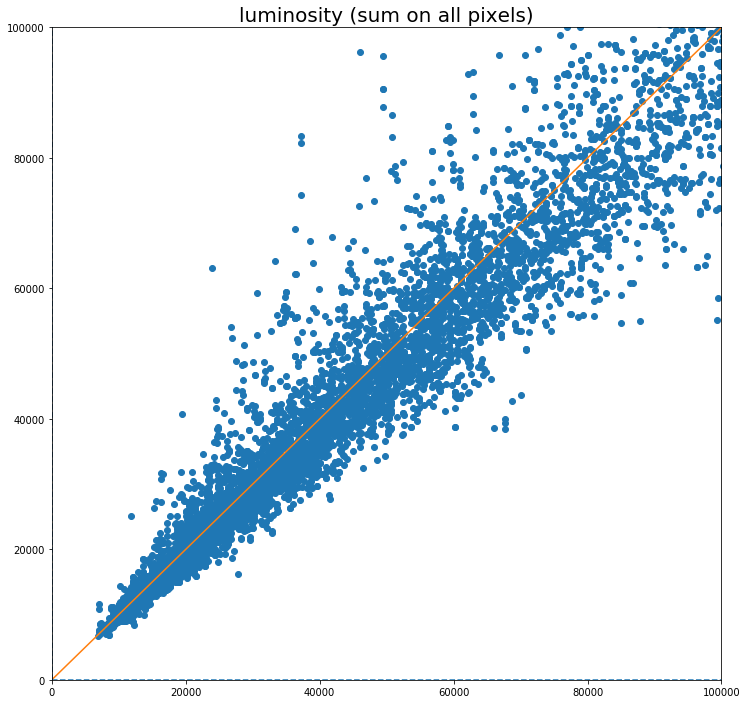

In [247]:
import matplotlib as mpl

fig, axes = plt.subplots(1,1, figsize=(12,12))
emax = 100000
axes.plot(lum_in_simple, lum_out_simple,'o')

axes.plot([-emax,+emax],[-emax,+emax])
axes.axhline(y=0, ls='--')
axes.axvline(x=0, ls='--')
axes.set_title('luminosity (sum on all pixels)', fontsize=20)#, color="w"
axes.spines['bottom']#.set_color('w')
axes.spines['right']#.set_color('w')
axes.spines['left']#.set_color('w')
axes.spines['top']#.set_color('w')
axes.xaxis.label#.set_color('w')
axes.tick_params(axis='x')#, colors='w')
axes.tick_params(axis='y')#, colors='w')
axes.set_xlim(0,emax)
axes.set_ylim(0,emax)

###### Delta_e as function of delta_mag and blendedness

In [248]:
delta_mag_arr = np.concatenate(delta_mag_arr, axis = 0)
max_blendedness_arr = np.concatenate(max_blendedness_arr, axis = 0)
delta_r_arr = np.concatenate(delta_r_arr, axis = 0)

In [253]:
test = np.where(delta_r_arr ==0)

In [63]:
test[0], test[0].shape

(array([   0,   12,   18, ..., 9989, 9993, 9998]), (2356,))

In [259]:
delta_test = np.delete(delta_e1, test[0], axis = 0)
max_blend = np.delete(max_blendedness_arr, test[0], axis = 0)

delta_mag_test = np.delete(delta_mag_arr, test[0], axis = 0)
delta_r_test = np.delete(delta_r_arr, test[0], axis = 0)

In [262]:
delta_mag_test.shape, delta_r_test.shape, max_blend.shape

((7672,), (7672,), (7672,))

(0, 10)

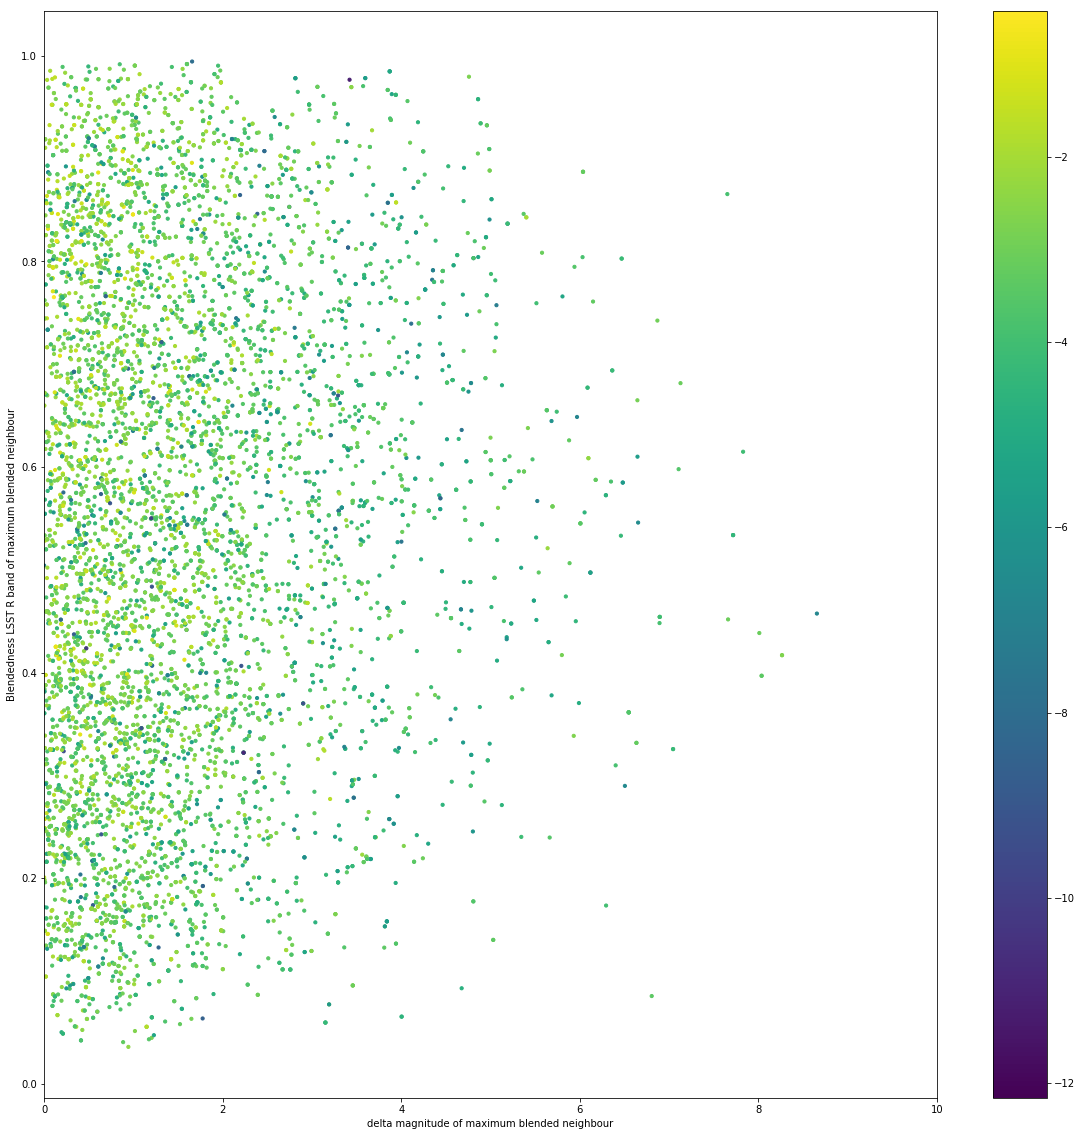

In [264]:
import matplotlib as mpl
fig, axes = plt.subplots(1, figsize=(20,20))

plt.scatter(delta_mag_test, max_blend,  c = np.log(np.abs(delta_test)), s=10)#, cmap=mpl.cm.gist_heat_r)#c = delta_e1,
plt.xlabel("delta magnitude of maximum blended neighbour")
plt.ylabel("Blendedness LSST R band of maximum blended neighbour")#delta r to closest (arcsecond)/scale radius of centered
plt.colorbar()
#plt.xscale('log')
plt.xlim(0,10)

###### Corner plot for latent space

In [17]:
batch_size = 100

In [18]:
a = batch_gen.__getitem__(2)
output_enc = encoder.predict(a[0], batch_size = batch_size)

In [19]:
latent_dim =32
epsilon_std = 1.0

In [20]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = np.random.normal( 0.,
                              epsilon_std,(batch_size, latent_dim))
    return z_mean + np.exp(z_log_var / 2) * epsilon


z = []
for i in range (100):
    a = batch_gen.__getitem__(2)
    output_enc = encoder.predict(a[0], batch_size = batch_size)
    z.append(sampling(output_enc))

In [21]:
z = np.concatenate(z, axis = 0)

/sps/lsst/users/barcelin/miniconda/envs/python_cpu4/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


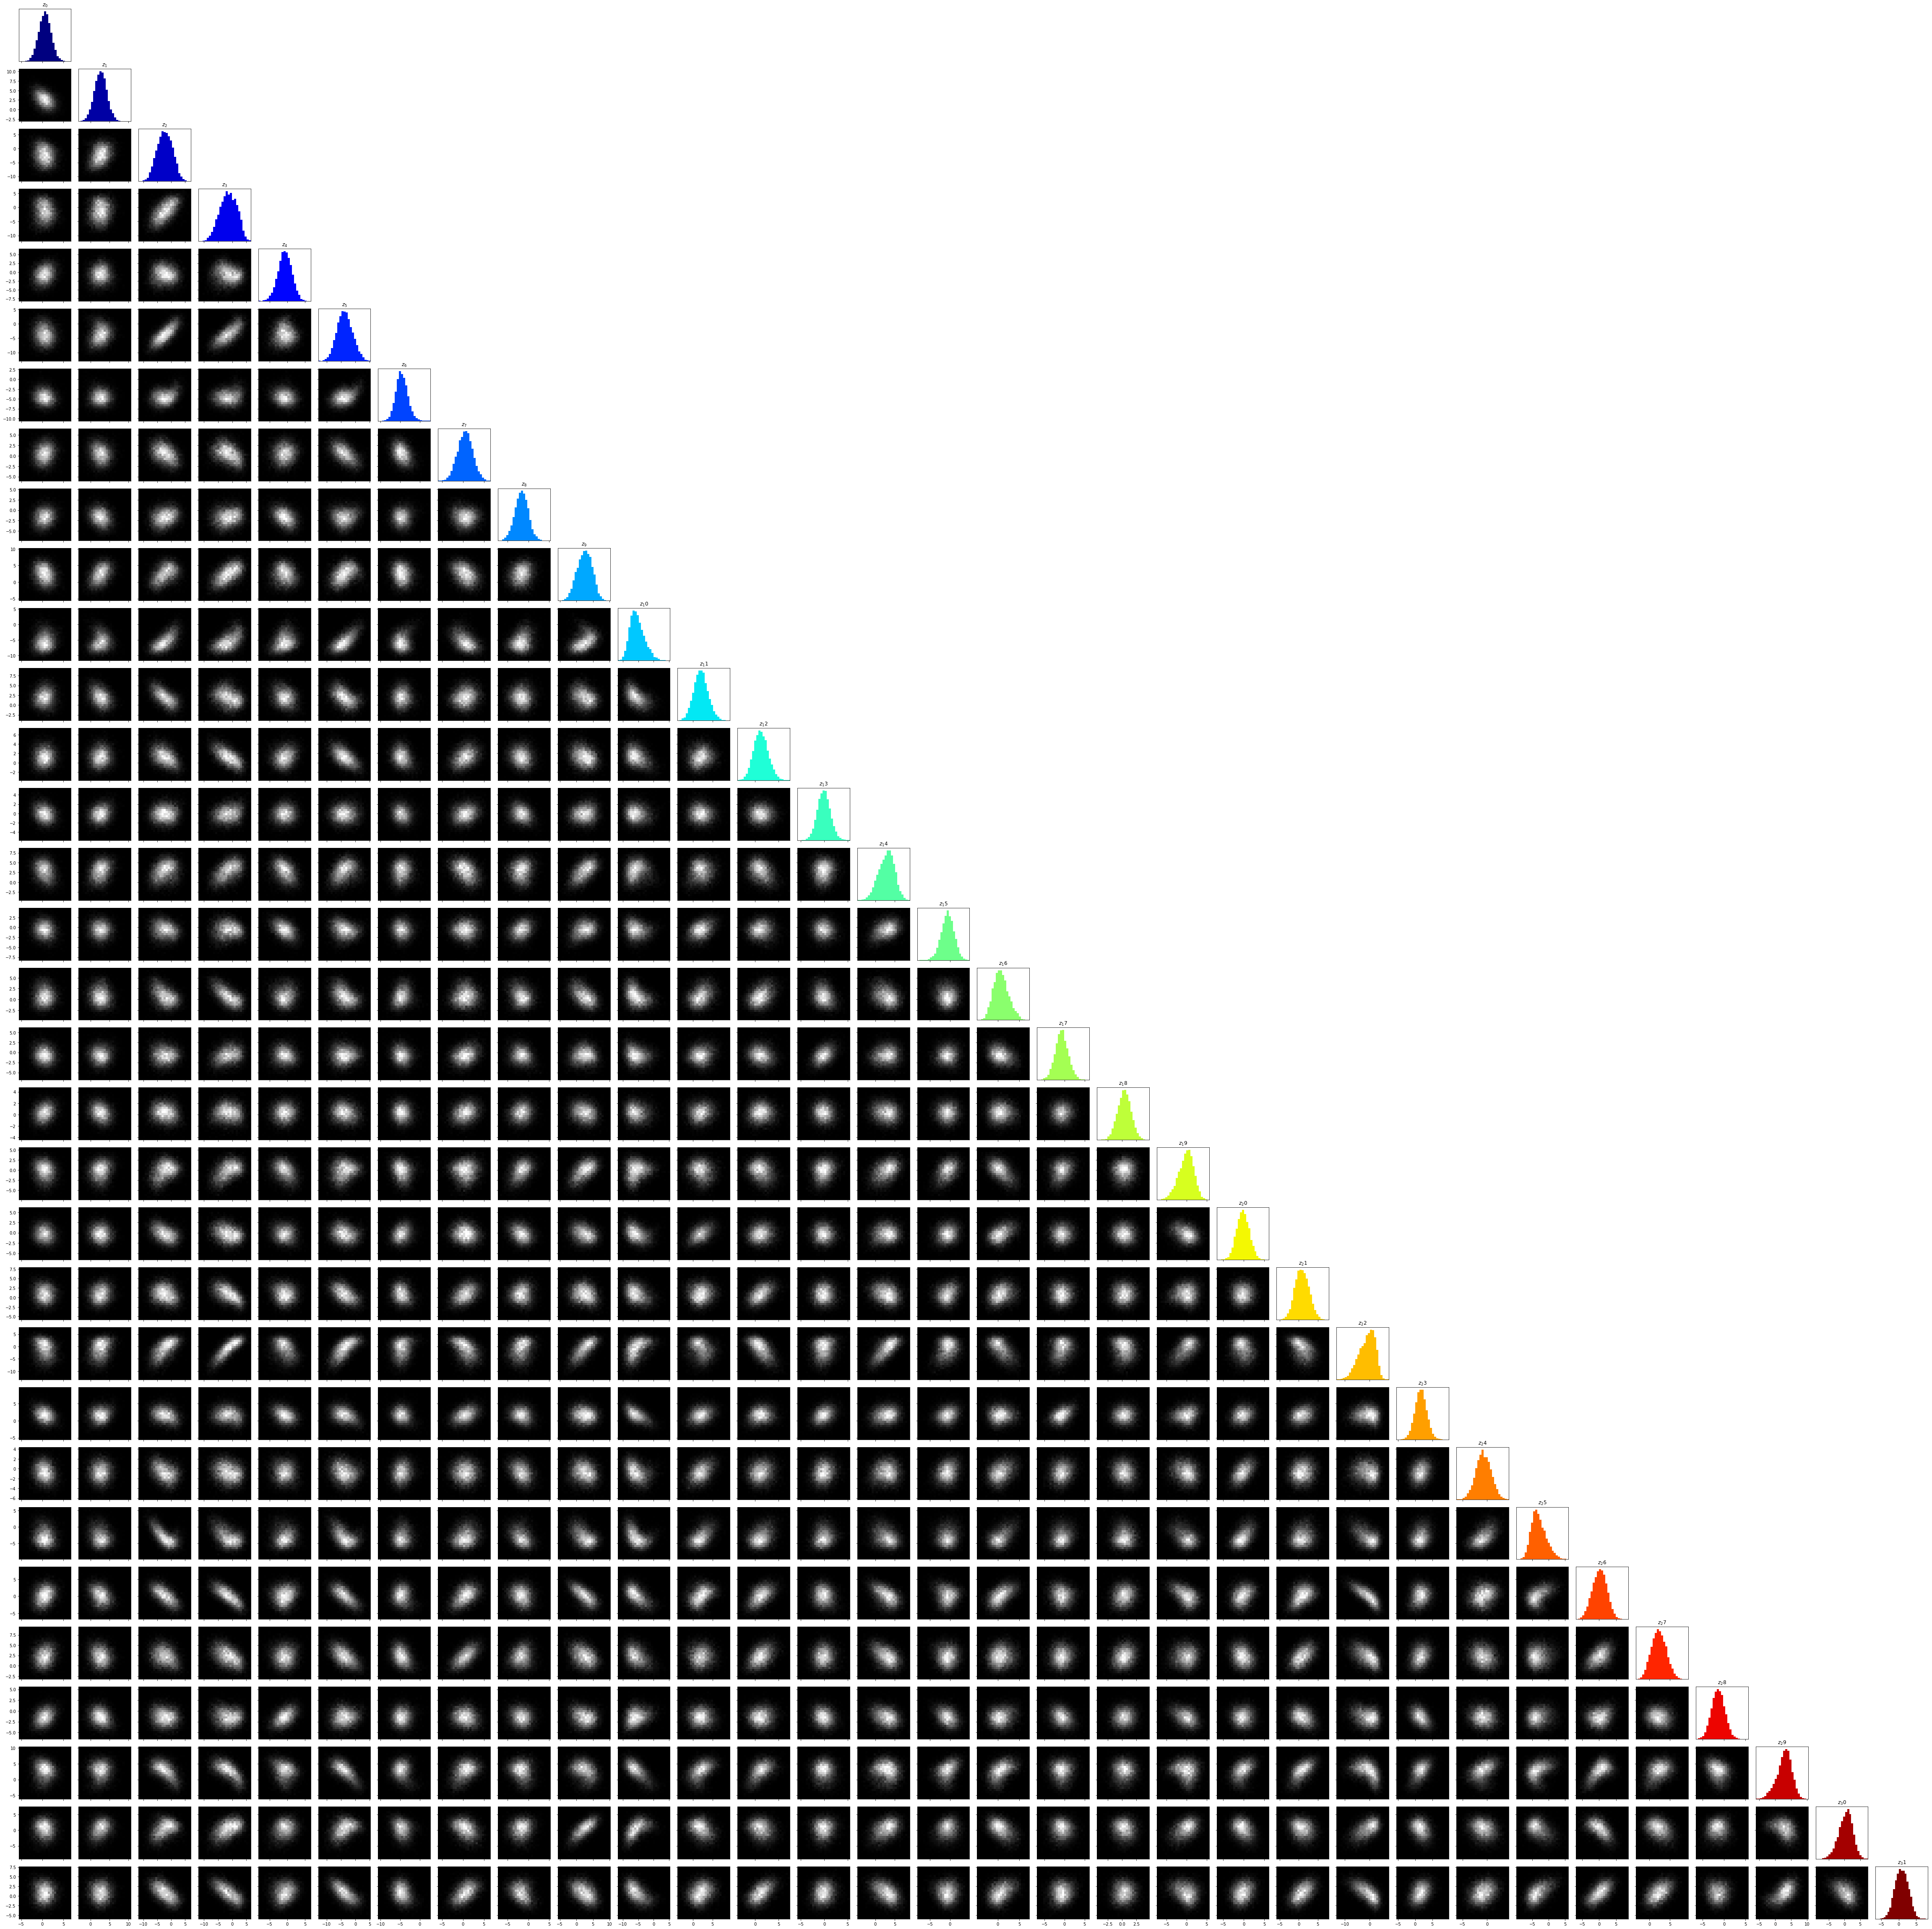

In [22]:
plot_corner_latent(z)

# Load the shifts to evaluate the distance between 2 galaxies

### Same analysis as function of delta r : all the images with only one galaxy are suppressed

In [14]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

band = 'i'

ellipticities = []
delta_r = []

for j in range(100):
    a = batch_gen.__getitem__(2)
    output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)#a[0] test[:,1,4:].reshape((10000,64,64,6))
    for i in range (len(a[0])):#a[0] test
        try: 
            if (a[2][i]!=0):
                gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])# 6, a[1][i] test[i,0,6]
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_in = [res.corrected_e1, res.corrected_e2]

                gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                gal_image.scale = pix_scale

                res = galsim.hsm.EstimateShear(gal_image, psf_image)
                e_out = [res.corrected_e1, res.corrected_e2]

                ellipticities.append([e_in, e_out])
                delta_r.append(a[2][i])
        except :
            print('error for galaxy '+str(j*100+i))
            pass
        continue

ellipticities_r_band = np.array(ellipticities)
delta_r_list = np.array(delta_r)

error for galaxy 851
error for galaxy 1145
error for galaxy 1919
error for galaxy 2022
error for galaxy 2785


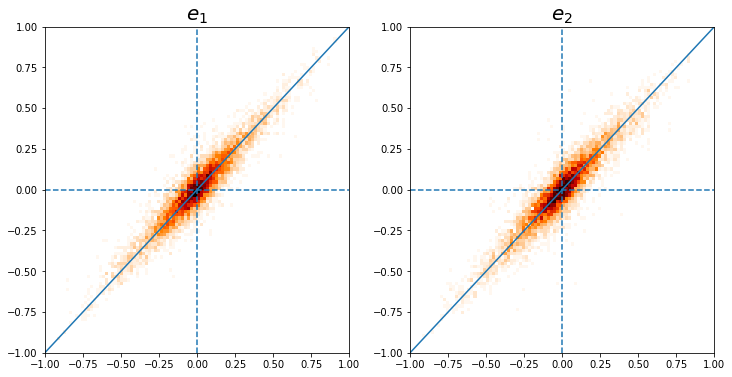

In [45]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [46]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

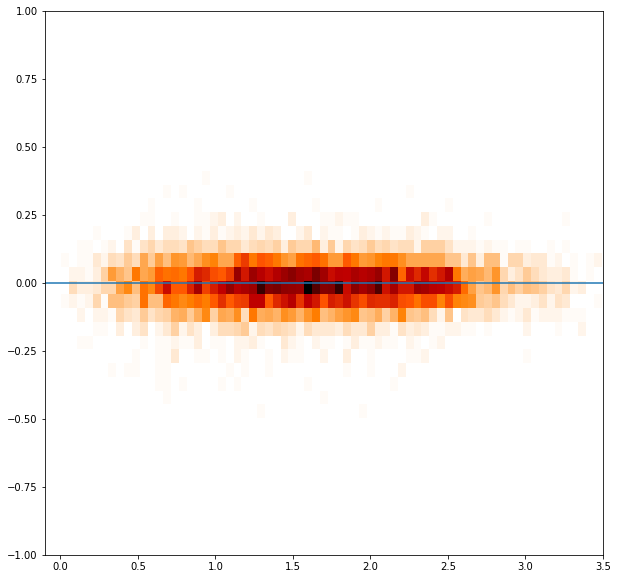

In [52]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

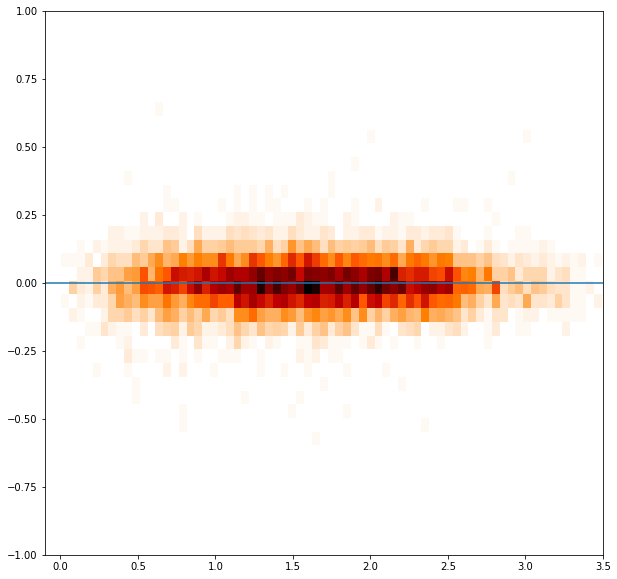

In [53]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e2, bins=np.linspace(-1,4,100), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

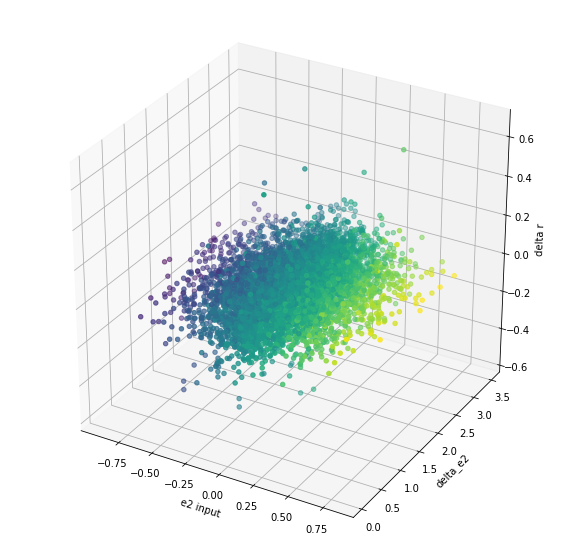

In [50]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,1]
ys = delta_r
zs = delta_e2
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e2 input')
ax.set_ylabel('delta_e2')
ax.set_zlabel('delta r')

plt.show()


### N sampling for the same galaxy on the 10 000 and take the mean

In [16]:
im_size = 64

batch_size =100
# see LSST Science Book
pix_scale = 0.2 #arcseconds
PSF_fwhm = 0.1
PSF_beta = 2.5

psf = galsim.Moffat(fwhm=PSF_fwhm, beta=PSF_beta)
psf_image = psf.drawImage(nx=im_size, ny=im_size, scale=pix_scale)

N_sampling = 100
N = 1

ellipticities_n = np.zeros((N_sampling, batch_size, 2,2 ))
ellipticities = []
delta_r = []
e = []


for j in range(N):
    a = batch_gen.__getitem__(2)
    for k in range (N_sampling):
        output_vae = deblender.predict(a[0].reshape((100,64,64,6)), batch_size = batch_size)

        for i in range (batch_size):
            if (a[2][i]!=0):
                try: 
                        gal_image = galsim.Image(a[1][i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_in = [res.corrected_e1, res.corrected_e2]
                        e_beta_in = [res.observed_shape.e, res.observed_shape.beta.rad]

                        gal_image = galsim.Image(output_vae[i].reshape((6,64,64))[2])
                        gal_image.scale = pix_scale

                        res = galsim.hsm.EstimateShear(gal_image, psf_image)
                        e_out = [res.corrected_e1, res.corrected_e2]
                        e_beta_out = [res.observed_shape.e, res.observed_shape.beta.rad]

                        ellipticities_n[k,i] = [e_in, e_out]
                        e.append([e_beta_in, e_beta_out])
                except :
                    print('error for galaxy '+str(j*100+i)+' sample '+str(k))
                    pass
                continue
                delta_r.append(a[2][i])
    print(np.array(ellipticities_n).shape)
    
    ellipticities.append(np.mean(np.array(ellipticities_n), axis = 0))
    print(np.array(ellipticities).shape)
        
        
ellipticities_r_band = np.array(ellipticities).reshape((100,2,2))
delta_r_list = np.array(delta_r)
e_beta = np.array(e)

(100, 100, 2, 2)
(1, 100, 2, 2)


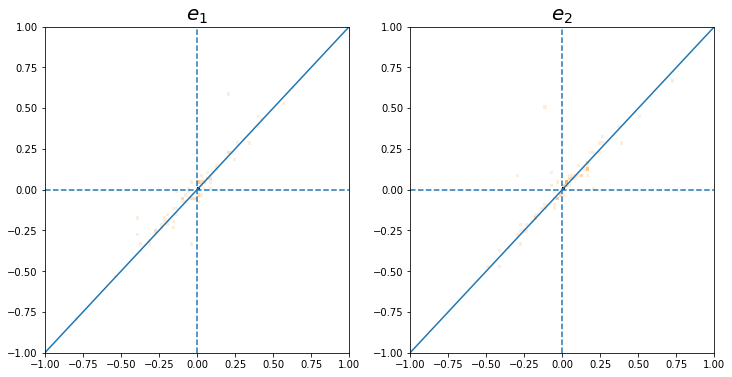

In [18]:
import matplotlib as mpl

fig, axes = plt.subplots(1,2, figsize=(12,6))
emax = 1
for i in range(2):
    _ = axes[i].hist2d(ellipticities_r_band[:,0,i], ellipticities_r_band[:,1,i], bins=np.linspace(-emax,+emax,101), cmap=mpl.cm.gist_heat_r)
    axes[i].plot([-emax,+emax],[-emax,+emax])
    axes[i].axhline(y=0, ls='--')
    axes[i].axvline(x=0, ls='--')
    axes[i].set_title('$e_{}$'.format(i+1),fontsize=20)# color="w", 
    axes[i].spines['bottom']#.set_color('w')
    axes[i].spines['right']#.set_color('w')
    axes[i].spines['left']#.set_color('w')
    axes[i].spines['top']#.set_color('w')
    axes[i].xaxis.label#.set_color('w')
    axes[i].tick_params(axis='x')#, colors='w'
    axes[i].tick_params(axis='y')#, colors='w'

In [24]:
delta_e1 = ellipticities_r_band[:,0,0]-ellipticities_r_band[:,1,0]
delta_e2 = ellipticities_r_band[:,0,1]-ellipticities_r_band[:,1,1]

ValueError: The dimension of bins must be equal to the dimension of the  sample x.

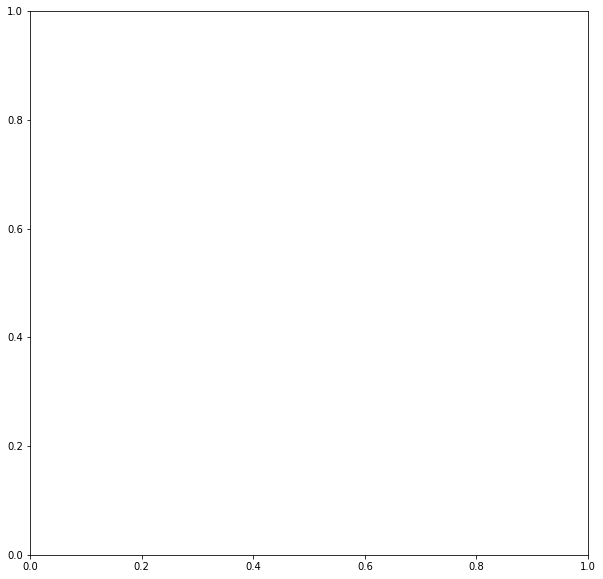

In [26]:
fig = plt.figure(figsize = (10,10))
_ = plt.hist2d(delta_r, delta_e1, bins=np.linspace(-1,4,10), cmap=mpl.cm.gist_heat_r)
plt.xlim(-0.1,3.5)
plt.ylim(-1,1)
plt.plot((-1, 4),(0,0))

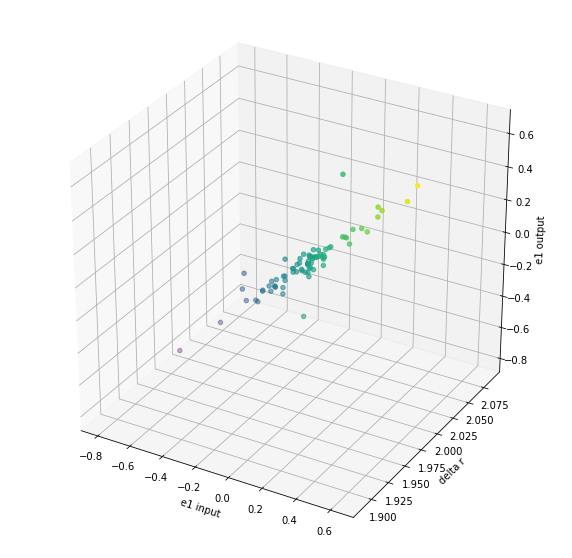

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')

xs = ellipticities_r_band[:,0,0]
ys = delta_r
zs = ellipticities_r_band[:,1,0]
ax.scatter(xs, ys, zs, c=xs, cmap='viridis')

ax.set_xlabel('e1 input')
ax.set_ylabel('delta r')
ax.set_zlabel('e1 output')

plt.show()

In [ ]:
# define the number of samplings
N = 3
nb_of_samplings = 10

batch_size = 100

In [ ]:
# Define the PSF used for measurement
PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
final_epsf_image = PSF.drawImage(scale=0.2)

In [ ]:
res_out_r_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_r_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e1 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')
res_out_lsst_euclid_e2 = np.empty([N,nb_of_samplings*batch_size], dtype='float32')


gal = []
err_count = 0

for i in range (N):
    list_galsim_simple=batch_gen_lsst_euclid.__getitem__(2)
    gal.append(list_galsim_simple[0][0])
    
    plt.imshow(list_galsim_simple[0][0].reshape((10,64,64))[6])#
    for k in range (len(list_galsim_simple[0])):
        list_galsim_simple[0][k] = gal[i]
    try: 
        print(i)
        for j in range (nb_of_samplings):
            print(j)
            output_vae_list_r = vae_lsst_r_band_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,6], batch_size = batch_size)
            output_vae_list_r = output_vae_list_r.reshape((batch_size,64,64))

            output_vae_list_lsst = vae_lsst_conv.predict(list_galsim_simple[0].reshape((batch_size,10,64,64))[:,4:].reshape((batch_size,64,64,6)), batch_size = batch_size)
            output_vae_list_lsst = output_vae_list_lsst.reshape((batch_size,6,64,64))

            output_vae_list_lsst_euclid = vae_lsst_euclid_conv.predict(list_galsim_simple[0], batch_size = batch_size)
            output_vae_list_lsst_euclid = output_vae_list_lsst_euclid.reshape((batch_size,10,64,64))

            for t in range (batch_size):
                img_out_simple = galsim.Image(output_vae_list_r[t])
                res_out_r_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_r_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst[t,2])
                res_out_lsst_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2

                img_out_simple = galsim.Image(output_vae_list_lsst_euclid[t,6])
                res_out_lsst_euclid_e1[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e1
                res_out_lsst_euclid_e2[i,j*batch_size+t] = galsim.hsm.EstimateShear(img_out_simple,final_epsf_image).observed_shape.e2
#print(res_out[i,j*batch_size+t])

            
            
    except :
        err_count +=1
        print('erreur')
        pass
    continue
            
print(err_count)

In [ ]:
res_in_e1 = np.empty([N], dtype='float32')
res_in_e2 = np.empty([N], dtype='float32')

for k in range (N):
#    try: 
    img_in_simple = galsim.Image(gal[k].reshape((10,64,64))[6])
    res_in_e1[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e1
    res_in_e2[k] = galsim.hsm.EstimateShear(img_in_simple,final_epsf_image).observed_shape.e2
    print(res_in_e1[k], res_in_e2[k])

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)


fig, axes = plt.subplots(2,3, figsize=(25,14))

ax = axes[0,0]
_ = ax.hist(res_out_r_e1[0],  bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[0], bins = 50,label ='LSST filters' ,  alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[0], bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)
variance = np.var(res_out_r_e1[0])
sigma = np.sqrt(variance)
x = np.linspace(min(res_out_r_e1[0]), max(res_out_r_e1[0]), 100)
#ax.plot(x, mlab.normpdf(x, mean, sigma))


ax.axvline(res_in_e1[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,1]
_ = ax.hist(res_out_r_e1[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e1[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e1')
ax.legend()

ax = axes[0,2]
_ = ax.hist(res_out_r_e1[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e1[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e1[2] , bins = 50,label = 'LSST+Euclid \n filters' ,  alpha = 0.5)

ax.axvline(res_in_e1[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e1')
ax.legend()

ax = axes[1,0]
_ = ax.hist(res_out_r_e2[0] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[0] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[0] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[0],color='g')
ax.set_title('Galaxy ' + str(1))
ax.set_ylabel('counts')
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,1]
_ = ax.hist(res_out_r_e2[1] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[1] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[1] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[1],color='g')
ax.set_title('Galaxy ' + str(2))
ax.set_xlabel('e2')
ax.legend()

ax = axes[1,2]
_ = ax.hist(res_out_r_e2[2] , bins = 50, label = 'R-band filter',alpha = 0.5)
_ = ax.hist(res_out_lsst_e2[2] , bins = 50, label ='LSST filters' , alpha = 0.5)
_ = ax.hist(res_out_lsst_euclid_e2[2] , bins = 50, label = 'LSST+Euclid \n filters' , alpha = 0.5)

ax.axvline(res_in_e2[2],color='g')
ax.set_title('Galaxy ' + str(3))
ax.set_xlabel('e2')
ax.legend()

plt.tight_layout()

# Compare deblender LSST vs LSST+Euclid

In [41]:
def compare_deblender(deb1, deb2,nb_1, nb_2, input_deb_1, input_deb_2, expected):
    ######
    # deb1, deb2 : the 2 deblenders which are being compared
    # nb_1, nb_2 : number of bands in the images processed respectively by deb1 and deb2
    # input_deb_1, input_deb_2 : the noisy blended images to process respectively for deb1 and deb2
    # expected: the noiseless centered galaxy images which are the targerts for the deblender 1
    ######
    # List of noisy blended images
    list_blended_1 = input_deb_1.reshape(len(input_deb_1),64,64,nb_1)
    list_blended_2 = input_deb_2.reshape(len(input_deb_2),64,64,nb_2)
    print(list_blended_1.shape)
    # List of noiseless centered galaxy
    list_simple = expected
    
    # Use deblenders on list of blended images
    list_output_1 = deb1.predict(list_blended_1, batch_size= 100)
    list_output_2 = deb2.predict(list_blended_2, batch_size= 100)
    
    # Reshape the lists so that it can be used for measurement
    list_output_1 = list_output_1.reshape(len(input_deb_1),nb_1,64,64)
    list_output_2 = list_output_2.reshape(len(input_deb_2),nb_2,64,64)
    print(list_output_1.shape)
    list_simple = list_simple.reshape(len(expected),nb_1,64,64)

    # Create empty lists for the futur measurements
    g_in = np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g1_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    g2_in= np.empty([100,],dtype='float32')#len(expected),], dtype='float32')
    
    g_out_1 = np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g1_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')
    g2_out_1= np.empty([100,],dtype='float32')#len(input_deb_1),], dtype='float32')

    g_out_2 = np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g1_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')
    g2_out_2= np.empty([100,],dtype='float32')#len(input_deb_2),], dtype='float32')

    err_count = 0
    for i in range (100):#len(input_deb_1)):
#        try :
        #print('image : '+str(i))
        # Add a PSF to be able to do an estimation of the shear
        PSF = galsim.Moffat(fwhm=0.1, beta=2.5)
        final_epsf_image = PSF.drawImage(scale=0.2)

        # Define the images
        img_in = galsim.Image(list_simple[i,nb_1-4,16:48,16:48])
        #print(list_blended_1.shape)
        img_out_1 = galsim.Image(list_output_1[i,nb_1-4,16:48,16:48])
        img_out_2 = galsim.Image(list_output_2[i,nb_2-4,16:48,16:48])
        #print(list_output_1[i,nb_1-4,16:48,16:48].shape, str(nb_1-4))
        #print(list_output_2[i,nb_2-4,16:48,16:48].shape, str(nb_2-4))
        #plt.imshow(list_output_1[i,nb_1-4])
        # Measurements 
        ## for the input image
        g_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g
        #print(g_in[i])
        g1_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g1
        #print(g1_in[i])
        g2_in[i] = galsim.hsm.EstimateShear(img_in,final_epsf_image).observed_shape.g2
        #print(g2_in[i])
        
        ## for the output image for the deblender deb1
        g_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g
        #print(g_out_1[i])
        g1_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g1
        #print(g1_out_1[i])
        g2_out_1[i] = galsim.hsm.EstimateShear(img_out_1,final_epsf_image).observed_shape.g2
        #print(g2_out_1[i])
        ## for the output image for the deblender deb2
        g_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g
        #print(g_out_2[i])
        g1_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g1
        #print(g1_out_2[i])
        g2_out_2[i] = galsim.hsm.EstimateShear(img_out_2,final_epsf_image).observed_shape.g2
        #print(g2_out_2[i])
#        except :
#            err_count +=1
#            print('erreur')
#            pass
#        continue
#    print(err_count)
    
    return g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2

In [42]:
g_in, g1_in, g2_in, g_out_1, g1_out_1, g2_out_1, g_out_2, g1_out_2, g2_out_2 = compare_deblender(deblender_lsst, deblender_lsst_euclid,6,10,input_deblender_lsst, input_deblender_lsst_euclid, input_deblender_no_noise_lsst)

(10000, 64, 64, 6)
(10000, 6, 64, 64)
image : 0
0.2082479
0.19913106
-0.060942654
0.036790792
0.034009717
-0.014032165
0.16499282
0.15605693
-0.0535618
image : 1
0.16798127
-0.026451362
0.1658856
0.15658477
-0.03602771
0.15238371
0.17420697
-0.019408643
0.17312242
image : 2
0.015851352
-0.0019065625
-0.015736276
0.08868295
-0.021780383
-0.085966736
0.02348353
-0.021882499
-0.008522464
image : 3
0.021669954
0.014525538
0.016080908
0.020390408
0.020253738
-0.002356865
0.03144208
0.021906106
0.022554975
image : 4
0.20160483
-0.0011992565
0.20160127
0.20832688
0.00688239
0.20821317
0.18581249
0.011259531
0.18547103
image : 5
0.23158796
-0.104689494
0.20657468
0.23533344
-0.12658247
0.19839028
0.2287074
-0.10791111
0.20164888
image : 6
0.11998794
-0.117808565
-0.022765057
0.07408505
-0.010791827
-0.07329482
0.10861742
-0.10680394
-0.01976517
image : 7
0.049526952
-0.0055145873
-0.049218982
0.04815506
0.0016616306
-0.04812638
0.06094573
-0.003158866
-0.06086381
image : 8
0.04619206
-0.017668

-0.12442082
0.10392915
0.04133713
-0.095354654
image : 74
0.11875908
0.112435594
0.03823554
0.12378496
0.122179255
0.01987324
0.08360412
0.076007724
0.034820616
image : 75
0.20552595
-0.003458937
-0.20549685
0.20924947
-0.036455277
-0.20604938
0.18458277
0.0022645297
-0.18456888
image : 76
0.13287856
-0.12798539
0.03572745
0.13762611
-0.13466565
0.02839205
0.14154579
-0.13268964
0.049281526
image : 77
0.12189686
0.05458897
0.10899032
0.04391239
0.040948823
0.015858488
0.12846608
0.053195484
0.11693492
image : 78
0.07118125
0.06414389
0.03085987
0.05739784
0.054537885
0.017892204
0.057015285
0.044195596
0.036020715
image : 79
0.3680707
0.28004238
0.23885626
0.36813596
0.26644644
0.25402832
0.36800182
0.25942957
0.2610012
image : 80
0.1587331
-0.07762931
-0.13845536
0.19166158
-0.09155821
-0.16837832
0.16123722
-0.09631994
-0.1293055
image : 81
0.05116644
-0.035789974
-0.036566135
0.052614756
0.0011119178
-0.052603006
0.037910182
0.0035725504
-0.03774147
image : 82
0.12260909
-0.06430983

In [43]:
# Calculate the differences from output measurement compared to input
## LSST
delta_g_lsst = g_in - g_out_1
delta_g1_lsst = g1_in- g1_out_1
delta_g2_lsst = g2_in-g2_out_1

## LSST + Euclid
delta_g_lsst_euclid = g_in - g_out_2
delta_g1_lsst_euclid = g1_in- g1_out_2
delta_g2_lsst_euclid = g2_in-g2_out_2


The history saving thread hit an unexpected error (OperationalError('disk I/O error',)).History will not be written to the database.


ValueError: weights should have the same shape as a.

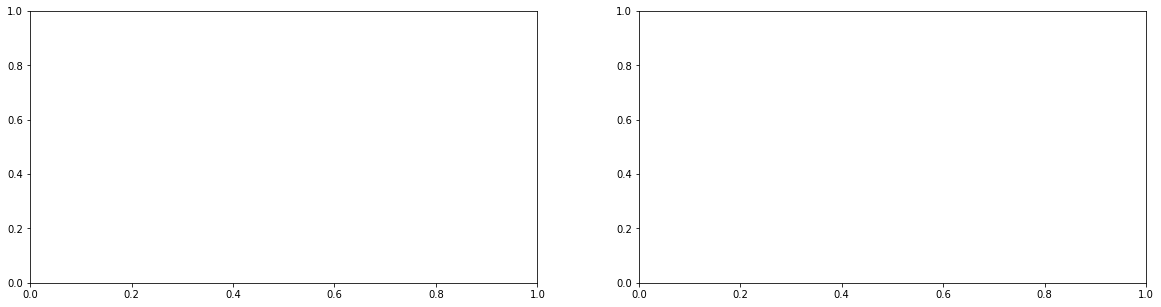

In [63]:
# Plot of the LSST and LSST+Euclid results comparison

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g, var_delta_g = mean_var(delta_r,delta_g_lsst_euclid,bins)
mean_delta_g1, var_delta_g1 = mean_var(delta_r,delta_g1_lsst_euclid,bins)
mean_delta_g2, var_delta_g2 = mean_var(delta_r,delta_g2_lsst_euclid,bins)

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r,delta_g2_lsst,bins)



ax = axes[0]
ax.plot(mid, mean_delta_g1, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g1 - 10*var_delta_g1**0.5, mean_delta_g1 + 10*var_delta_g1**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2, label = 'LSST-EUCLID')
ax.fill_between(mid, mean_delta_g2 - 10*var_delta_g2**0.5, mean_delta_g2 + 10*var_delta_g2**0.5, alpha=0.5)
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.plot(mid,mid*0)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

### Only the LSST results

In [ ]:
# Plot of the LSST results only

ig, axes = plt.subplots(1, 2, figsize=(20, 5))

bins = np.linspace(0, 50,100)
mid = (bins[1:]+bins[:-1])*0.5

mean_delta_g_lsst, var_delta_g_lsst = mean_var(delta_r_2,delta_g_lsst,bins)
mean_delta_g1_lsst, var_delta_g1_lsst = mean_var(delta_r_2,delta_g1_lsst,bins)
mean_delta_g2_lsst, var_delta_g2_lsst = mean_var(delta_r_2,delta_g2_lsst,bins)


#ax = axes[0]
#ax.plot(mid,mean_delta_g_lsst, label = 'LSST')
#ax.fill_between(mid, mean_delta_g_lsst - 10*var_delta_g_lsst**0.5, mean_delta_g_lsst + 10*var_delta_g_lsst**0.5, alpha=0.5)
#ax.set_ylabel('delta g', fontsize = 10)
#ax.set_xlabel('delta r', fontsize = 10)
#ax.legend(fontsize = 10)
#ax.set_xlim(0,40)
#ax.set_ylim(-0.5,0.5)

ax = axes[0]
ax.plot(mid, mean_delta_g1_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g1_lsst - 10*var_delta_g1_lsst**0.5, mean_delta_g1_lsst + 10*var_delta_g1_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g1', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)

ax = axes[1]
ax.plot(mid, mean_delta_g2_lsst, label = 'LSST')
ax.plot(mid,mid*0)
ax.fill_between(mid, mean_delta_g2_lsst - 10*var_delta_g2_lsst**0.5, mean_delta_g2_lsst + 10*var_delta_g2_lsst**0.5, alpha=0.5)
ax.set_ylabel('delta g2', fontsize = 10)
ax.set_xlabel('delta r', fontsize = 10)
ax.legend(fontsize = 10)
ax.set_xlim(0,40)
ax.set_ylim(-0.5,0.5)